<a href="https://colab.research.google.com/github/joeldcosta/DrosteEffect/blob/main/Droste_Effect_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Create Droste Effect Using Python

In [85]:
#@title Remove sample_data
!rm -rf sample_data

In [100]:
#@markdown Download image from web
import os
Download_Image = "https://m.media-amazon.com/images/I/812L5zyAmpL._AC_SX522_.jpg" #@param {type:"string"}
os.popen(f"""wget {Download_Image} -O 'test.jpg'""").read()
#!wget "https://previews.123rf.com/images/mediagram/mediagram1610/mediagram161000011/66182163-%E5%8F%A4%E4%BB%A3%E3%81%AB%E3%81%AF%E7%99%BD%E3%81%84%E8%83%8C%E6%99%AF%E3%81%AB%E5%88%86%E9%9B%A2%E3%81%95%E3%82%8C%E3%81%9F%E6%99%82%E8%A8%88%E3%81%AE%E6%96%87%E5%AD%97%E7%9B%A4%E3%81%8C%E7%A0%B4%E6%90%8D%E3%81%97%E3%81%A6%E3%81%84%E3%81%BE%E3%81%99%E3%80%82.jpg" -O 'test.jpg'
print("Downloaded as test.jpg!!!")

Downloaded as test.jpg!!!


In [121]:
#@title ***Droste Effect Input***
import numpy as np
import cv2
import random
#import sys
import os.path
from IPython.display import Image
# Math explained here: http://www.josleys.com/article_show.php?id=82

class Droste:
    def __init__(self, fPath, repeatsX, repeatsY, r1, r2, xRange, yRange, resultFolderAddress):
        self.repeatsX = repeatsX
        self.repeatsY = repeatsY
        self.r1 = min(r1, r2)
        self.r2 = max(r1, r2)
        self.inputImg = cv2.imread(fPath, cv2.IMREAD_UNCHANGED) #returns a matrix-like object
        self.xRange = xRange
        self.yRange = yRange
        self.resultFolderAddress = resultFolderAddress

    def Transform(self, method):
        # Builds  new plane
        img, r, c, Z = self.CreateComplexPlane()
        if method == 1:
            # 1: Ln -> Tile   -> Rotate -> exponent
            self.Calculate1(Z, r, c)  # takes in the complex plane, outputs the transformed plane
        else:
            # 0: Ln -> Rotate -> Tile   -> exponent
            self.Calculate(Z, r, c)  # takes in the complex plane, outputs the transformed plane


    def CreateComplexPlane(self):
        '''
        :param self: loads the input image
        :return: the image as matrix, nbr of rows, nbr of cols, complex plane
        '''
        img = self.inputImg
        r = img.shape[0] #nbr of rows
        c = img.shape[1] #nbr of cols
        x = np.linspace(-self.xRange, self.xRange, num=r, endpoint=True, dtype=np.float32) #Returns an array of evenly spaced numbers over a specified interval.
        y = np.linspace(-self.yRange, self.yRange, num=c, endpoint=True, dtype=np.float32)
        X, Y = np.meshgrid(x, y, indexing='ij') #creates rect grid off arrays, here it uses Matrix indexing. Returns X, Y coordinates
        Z = X + (1j * Y); # Transf to the Complex Plane (then we will transform back to Cartesian) 1J is the imaginary part.
        return img, r, c, Z



    def TILE(self, W, r, c, repeatX, repeatY):
        X = W.real
        Y = W.imag

        xOffset = np.log(self.r2 / self.r1)
        repeatYHalf = int((repeatY - 1)/2)
        repeatXHalf = int((repeatX - 1)/2)
        for i in range(-repeatYHalf, repeatYHalf + 1):
            W2 = None
            for j in range(-repeatXHalf, repeatXHalf + 1):
                if 0 == repeatXHalf + j:
                    W2 = X + j * xOffset + (Y + 2 * np.pi * i) * 1j
                else:
                    W2 = np.concatenate([W2, X + j * xOffset + (Y + np.pi*2*i) * 1j], axis=0)
            if 0 == repeatYHalf + i:
                W1 = W2
            else:
                W1 = np.concatenate([W1, W2], axis=1)
        return W1


    def TILE2(self, W, X, Y, repeatX, repeatY):
        X = W.real
        Y = W.imag

        repeatYHalf = int((repeatY - 1)/2)
        repeatXHalf = int((repeatX - 1)/2)

        alpha = np.arctan2(np.log(max(self.r2,self.r1) / min(self.r1, self.r2)), 2 * np.pi) # we need alpha to calculate the offsets
        cosine = np.cos(alpha)
        sine = np.sin(alpha)
        yOffset = 2 * np.pi * sine * sine
        xOffset = 2 * np.pi * sine * cosine

        for i in range(-repeatYHalf, repeatYHalf + 1):
            W2 = None
            for j in range(-repeatXHalf, repeatXHalf + 1):
                if 0 == repeatXHalf + j:
                    W2 = X + j * xOffset + ((Y + (2 * np.pi * i + yOffset * j)) * 1j)
                else:
                    W2 = np.concatenate([W2, X + j * xOffset + ((Y + (2 * np.pi * i + yOffset * j)) * 1j)], axis=0)
            if 0 == repeatYHalf + i:
                W1 = W2
            else:
                W1 = np.concatenate([W1, W2], axis=1)

        return W1



    def LogTransform(self, Z, r, c):
        '''
        :param Z: Complex plane
        :param r: nbr of rows
        :param c: nbr of cols
        :return: np.log(z / min(r1, r2))
        '''
        Z1 = np.zeros([r, c], dtype=complex)

        ZAbs = np.absolute(Z)
        elemetsToApplyTransformation = (self.r1 <= ZAbs) & (ZAbs <= self.r2)

        Z1[elemetsToApplyTransformation] = np.log(Z[elemetsToApplyTransformation])

        return Z1


    def ExponentTransform(self, Z, r, c, repeatX, repeatY):
        Z1 = Z[:r * repeatX, :c * repeatY].copy()
        Z1 = np.exp(Z)
        return Z1


    def RotationTransform(self, Z, r, c, repeatX, repeatY):
        Z1 = Z[:r * repeatX, :c * repeatY].copy()
        alpha = np.arctan2(np.log(self.r2 / self.r1), 2 * np.pi)
        f = np.cos(alpha)

        Z1 = Z * f * np.exp(1j * alpha)
        return Z1


    def Calculate(self, Z, r, c):
        print(Z.shape)
        W1 = self.LogTransform(Z, r, c)
        # self.ReCreateImageAndSave(W1, "log-{}.{}-{}.{}-{}.jpg".format(0, self.r1, self.r2, 1, 1), r, c, 1, 1)

        W1 = self.RotationTransform(W1, r, c, 1, 1)
        # self.ReCreateImageAndSave(W1, "rot-{}.{}-{}.{}-{}.jpg".format(0, self.r1, self.r2, 1, 1), r, c, 1, 1)

        repeatX = self.repeatsX
        repeatY = self.repeatsY
        W1 = self.TILE2(W1, r, c, repeatX, repeatY)
        print(W1.shape)
        # self.ReCreateImageAndSave(W1, "tile-{}.{}-{}.{}-{}.jpg".format(0, self.r1, self.r2, repeatX, repeatY), r, c, repeatX, repeatY)

        W1 = self.ExponentTransform(W1, r, c, repeatX, repeatY)
        self.ReCreateImageAndSave(W1, "final-{}.{}-{}.{}-{}.jpg".format(0, self.r1, self.r2, repeatX, repeatY), r, c, repeatX, repeatY)
        return W1
        
    def Calculate1(self, Z, r, c):
        print(Z.shape)
        # apply Ln(z/r1)
        W1 = self.LogTransform(Z, r, c)
        # self.ReCreateImageAndSave(W1, "log-{}.{}-{}.{}-{}.jpg".format(1, self.r1, self.r2, 1, 1), r, c, 1, 1)

        # choose how many tiles we want to add
        repeatX = self.repeatsX
        repeatY = self.repeatsY
        # apply Tile
        W1 = self.TILE(W1, r, c, repeatX, repeatY)
        print(W1.shape)
        # self.ReCreateImageAndSave(W1, "rot-{}.{}-{}.{}-{}.jpg".format(1, self.r1, self.r2, repeatX, repeatY), r, c, repeatX, repeatY)

        # apply Rotation
        W1 = self.RotationTransform(W1, r, c, repeatX, repeatY)
        # self.ReCreateImageAndSave(W1, "tile-{}.{}-{}.{}-{}.jpg".format(1, self.r1, self.r2, repeatX, repeatY), r, c, repeatX, repeatY)

        # apply exponent
        W1 = self.ExponentTransform(W1, r, c, repeatX, repeatY)
        self.ReCreateImageAndSave(W1, "final-{}.{}-{}.{}-{}.jpg".format(1, self.r1, self.r2, repeatX, repeatY), r, c, repeatX, repeatY)
        return W1
        Image(open(W1, "final-{}.{}-{}.{}-{}.jpg".format(0, self.r1, self.r2, repeatX, repeatY), r, c, repeatX, repeatY,'rb').read())


    def makeNewXY(self, W, wmax, x):
        return np.multiply(np.add(np.divide(W, wmax), 1), x / 2)

    def GetNewXY(self, W, r, c, repeatX, repeatY):
        Wx = np.real(W)
        Wy = np.imag(W)
        wxmax = np.absolute(Wx).max()
        wymax = np.absolute(Wy).max()
        XNew = self.makeNewXY(Wx, wxmax, c * repeatY)
        YNew = self.makeNewXY(Wy, wymax, r * repeatX)
        return XNew, YNew

    def ReCreateImage(self, Xnew, Ynew, img, r, c, repeatX, repeatY):
        '''
        :param Xnew:
        :param Ynew:
        :param img:
        :param r:
        :param c:
        :param repeat:
        :return: A matrix representing the pic in the new coordinates
        '''
        # newImg = np.zeros([r * repeatX, c * repeatY, 3])
        imgList = img.tolist()
        XnewList = Xnew.tolist()
        YnewList = Ynew.tolist()
        newImgList = [[[0, 0, 0] for j in range(c * repeatY)] for i in range(r * repeatX)]
        for i in range(r * repeatX):
            for j in range(c * repeatY):
                if int(XnewList[i][j]) == c * repeatY:
                    XnewList[i][j] = c * repeatY - 1
                if int(YnewList[i][j]) == r * repeatX:
                    YnewList[i][j] = r * repeatX - 1
                newImgList[int(YnewList[i][j])][int(XnewList[i][j])] = imgList[i % r][j % c][:3] # extract RGB from inputImage
        newImg = np.array(newImgList)
        return newImg

    # I know this is overkill
    # need to find a opencv equivalent
    # if you know tell me plz :)
    def FixBlackPixels(self, img, r, c, repeatX, repeatY):
        global image, limitR, limitC
        black = [0,0,0]
        image = img
        limitR = r * repeatX - 1
        limitC = c * repeatY - 1
        imgList = img.tolist()
        for i in range(limitR):
            for j in range(limitC):
                if imgList[i][j] == black:
                    n = 0
                    temp = [0,0,0]
                    # diagonal screws the result
                    for u, v in [(1, 0), (-1, 0), (2, 0), (-2, 0), (0, 1), (0, -1), (0, 2), (0, -2)]:
                        if not (u == 0 and v == 0):
                            if 0 <= i + u and i + u <= limitR and 0<= j + v and j + v <= limitC:
                                if imgList[i + u][j + v] != black:
                                    n += 1
                                    temp = [imgList[i + u][j + v][k] + temp[k] for k in range(3)]
                    if n != 0:
                        imgList[i][j] = [temp[k] / n for k in range(3)]

        img = np.array(imgList)
        return img



    def ReCreateImageAndSave(self, W, imgTitle, r, c, repeatX, repeatY):
        xNew, yNew = self.GetNewXY(W, r, c, repeatX, repeatY)
        img = self.ReCreateImage(xNew, yNew, self.inputImg, r, c, repeatX, repeatY)
        img = self.FixBlackPixels(img, r, c, repeatX, repeatY)

        # img[blackPixels] = cv2.blur(img.astype(np.float32), (5, 5))
        # img = cv2.medianBlur(img.astype(np.float32), 5)
        cv2.imwrite(self.resultFolderAddress + '/' + imgTitle, img)


def only_odd():
  lst = []
  for i in range(0,100):
    ele = int(i)
    lst.append(ele)
  return [num for num in lst if num % 2 == 1]


def GetCommandLineArgs():
    '''
    Gets command line argumets, does some error checking.
    :return: command line arguments
             fPath must be valid
             method must be 0 or 1
             repeats must be positive and odd
    '''  
    #@markdown Address of input picture
    fPath = '/content/test.jpg' #@param {type:"string"}
    #@markdown Method number is either 0 or 1
    method_ = "0" #@param [0, 1] 
    #@markdown RepeatsX must be positive and odd
    repeatsX_ = "3" #@param [1, 3, 5, 7, 9]
    #@markdown RepeatsY must be positive and odd
    repeatsY_ = "5" #@param [1, 3, 5, 7, 9]
    method = int(method_)
    repeatsX = int(repeatsX_)
    repeatsY = int(repeatsY_)
    if not os.path.isfile(fPath):
      print("Input picture does not exist")
    if not (method == 0 or method == 1):
      print("Method must be 0 or 1")
    if repeatsX <= 0 or repeatsX & 1 == 0:
      print("Repeats must be positive and odd")
    if repeatsY <= 0 or repeatsY & 1 == 0:
      print("Repeats must be positive and odd")
    return fPath, method, repeatsX, repeatsY
  

def CreateOutputFolder(inputImagePath, repeatsX, repeatsY, method, r1, r2):
    '''
    :param inputImagePath: address of our input image
    :param repeats:        number of repeats
    :return: address of the result folder
    '''
    inputImageName = inputImagePath.split('/')[-1] # extract input image name
    outputFolder = "OutputImages/"        # pictures will be stored

    resultFolderAddress = outputFolder + inputImageName + "-{}.{}-{}.{}-{}.jpg".format(method, r1, r2, repeatsX, repeatsY) # the folder that our code is stored in
    if not os.path.exists(resultFolderAddress): # create the result folder
        os.makedirs(resultFolderAddress)
    return resultFolderAddress

def main():
    inputImagePath, method, repeatsX, repeatsY = GetCommandLineArgs()
    # We have two methods of calculating the result
    # 0: Ln -> Rotate -> Tile   -> exponent
    # 1: Ln -> Tile   -> Rotate -> exponent
    #@markdown inner circle radius 0.2 
    r1_ = "0.2" #@param[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    r1 = float(r1_)
    #@markdown outer circle radius 0.9     
    r2_ = "0.9" #@param[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]   
    r2 = float(r2_)

    resultFolderAddress = CreateOutputFolder(inputImagePath, repeatsX, repeatsY, method, r1, r2)

    d = Droste(inputImagePath, repeatsX, repeatsY, r1, r2, -1, 1, resultFolderAddress)
    print('be patient...')
    d.Transform(method)


if __name__ == "__main__":
    main()


be patient...
(521, 522)
(1563, 2610)


File Saved!!!


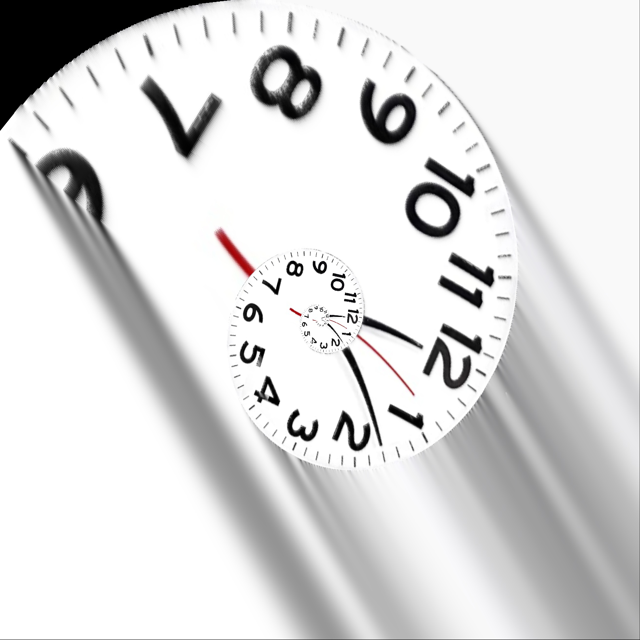

In [122]:
#@title Resize Image *Copy paste path here
from PIL import Image
from IPython.display import Image as Image_

Image_to_Correct = "/content/OutputImages/test.jpg-0.0.2-0.9.3-5.jpg/final-0.0.2-0.9.3-5.jpg"#@param {type:"string"}
image = Image.open(Image_to_Correct)
width, height = image.size

#@markdown Size:- SD 480p || HD 720p || HD 1080p || 4K 2160p
add_size_ = "640" #@param [640,1280,1920,3840]
add_size = int(add_size_)

remain_adw = add_size - width
remain_adh = add_size - height

new_image = image.resize((width+remain_adw,height+remain_adh))
if add_size == 640:
  sd = 'newsize_SD_480p.png'
  new_image.save(sd)
  fl = sd 
if add_size == 1280:
  HD = 'newsize_HD_720p.png'
  new_image.save(HD)
  fl = HD
if add_size == 1920:
  HDD = 'newsize_HD_1080p.png'
  new_image.save(HDD)
  fl = HDD
if add_size == 3840:
  _4K = 'newsize_4K_2160p.png'
  new_image.save(_4K)
  fl = _4K

print("File Saved!!!")
Image_(filename = fl, width = 512, height = 512) 


In [103]:
# @markdown # Download Your File
from google.colab import files
files.download(fl)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>